Análise e classificação de mensagens SMS entre Spam e Não Spam. Dados disponíveis em: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

### Importação de Pacotes

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

### Importação de dados

In [79]:
df = pd.read_csv('SMSSpamCollection', sep='\t', names = ('label','message'), index_col = False)
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Renomear as labels:

In [80]:
df['label']=df['label'].replace('ham',0).replace('spam',1)
df['label'].value_counts()

0    4825
1     747
Name: label, dtype: int64

In [81]:
df['label'].isnull().sum()

0

### Tratamento

In [82]:

sw = set(stopwords.words('english'))   
lemmatizer = WordNetLemmatizer()           
def tratamento(text):

    text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)      #Remove tudo que não for a-z, A-Z ou 0-9. 
    
    text = text.lower()

    str = word_tokenize(text)

    filtered_words = [word for word in str if word not in sw]        

    lemm_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    return lemm_words


df['clean_text'] = df['message'].apply(lambda x: tratamento(x))
df['text'] = df['clean_text'].apply(lambda x: ' '.join(x))
df.drop(columns=['clean_text','message'], axis='columns', inplace=True)

### Modelo

Rodando o modelo com Logistic Regression:

In [83]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classifier = LogisticRegression()
pipeline = Pipeline([('tfidf', TfidfVectorizer()),('c', classifier)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

Resultados:

In [84]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1448
           1       0.98      0.79      0.87       224

    accuracy                           0.97      1672
   macro avg       0.98      0.89      0.93      1672
weighted avg       0.97      0.97      0.97      1672

0.9694976076555024


Curva Roc:

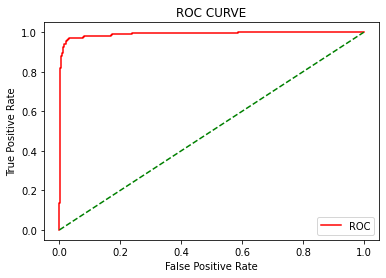

In [85]:
y_proba = pipeline.predict_proba(X_test)
y_proba = y_proba[:, 1]
fp, tp, thresholds = roc_curve(y_test, y_proba)
plt.plot(fp, tp, color = 'red', label = 'ROC')
plt.plot([0,1], [0,1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend()
plt.show()

In [86]:
print(roc_auc_score(y_test, y_proba))

0.9915770520915548


Tentemos o mesmo processo com outro estimador:

In [87]:
#Utilizando Random Forest
classifier_rf = RandomForestClassifier()
pipeline_rf = Pipeline([('tfidf', TfidfVectorizer()),('c', classifier_rf)])
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

In [88]:
print(classification_report(y_test, y_pred_rf))
print(accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       1.00      0.86      0.93       224

    accuracy                           0.98      1672
   macro avg       0.99      0.93      0.96      1672
weighted avg       0.98      0.98      0.98      1672

0.9814593301435407


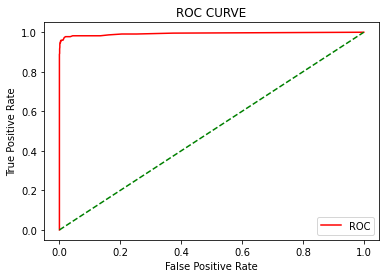

In [89]:
y_proba_rf = pipeline_rf.predict_proba(X_test)
y_proba_rf = y_proba_rf[:, 1]
fp, tp, thresholds = roc_curve(y_test, y_proba_rf)
plt.plot(fp, tp, color = 'red', label = 'ROC')
plt.plot([0,1], [0,1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend()
plt.show()

In [90]:
print(roc_auc_score(y_test, y_proba_rf))

0.9934978048539858


Utilizando Stemming ao invés de lemming:

In [91]:
stemmer = PorterStemmer()  

def tratamento_stem(text):

    text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)      #Remove tudo que não for a-z, A-Z ou 0-9. Símbolo ^ indica negação.
    
    text = text.lower()

    str = word_tokenize(text)

    filtered_words = [word for word in str if word not in sw]          #Lista de tokens sem stopwords

    stem_words = [stemmer.stem(word) for word in filtered_words]

    return stem_words

df_2 = pd.read_csv('SMSSpamCollection', sep='\t', names = ('label','message'), index_col = False)
df_2['label']=df_2['label'].replace('ham',0).replace('spam',1)
df_2['clean_text'] = df_2['message'].apply(lambda x: tratamento_stem(x))
df_2['text'] = df_2['clean_text'].apply(lambda x: ' '.join(x))
df_2.drop(columns=['clean_text','message'], axis='columns', inplace=True)
X = df_2['text']
y = df_2['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classifier = LogisticRegression()
pipeline = Pipeline([('tfidf', TfidfVectorizer()),('c', classifier)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1448
           1       0.98      0.80      0.88       224

    accuracy                           0.97      1672
   macro avg       0.98      0.90      0.93      1672
weighted avg       0.97      0.97      0.97      1672

0.97188995215311


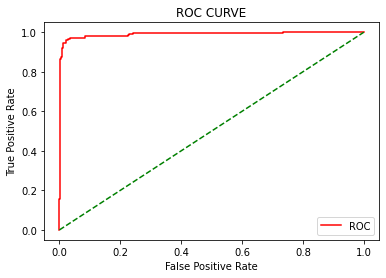

0.9905750542620363


In [92]:
y_proba = pipeline.predict_proba(X_test)
y_proba = y_proba[:, 1]
fp, tp, thresholds = roc_curve(y_test, y_proba)
plt.plot(fp, tp, color = 'red', label = 'ROC')
plt.plot([0,1], [0,1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend()
plt.show()
print(roc_auc_score(y_test, y_proba))

Os resultados são semelhantes. Façamos então uma verificação na própria base com os valores reais e preditos:

In [93]:
X_test = pd.DataFrame(X_test)
X_test['label'] = y_test
X_test['predict'] = y_pred.tolist()

In [94]:
X_test[X_test['predict']==1].head(30)

,text,label,predict
401,free rington text first 87131 poli text get 87...,1,1
2952,hey free call,0,1
5567,2nd time tri 2 contact u u 750 pound prize 2 c...,1,1
1961,guess somebodi know secretli fanci wan na find...,1,1
2664,8007 free 1st week no1 nokia tone 4 ur mob eve...,1,1
1598,urgent mobil number award 2000 prize guarante ...,1,1
3299,messag free welcom new improv sex dog club uns...,1,1
4500,sm servic inclus text credit pl goto www comuk...,1,1
296,mobil custom may claim free camera phone upgra...,1,1
3298,today voda number end 5226 select receiv 350 a...,1,1
